# Public COVID-19 data exploration

In this notebook we pull data from various internet sources, manipulate and plot it to examine it in various ways.

There are a number of data banks we can pull from. Four we have discussed are:
- John Hopkins University (JHU).
- New York Times (NYT).
- European CDC (ECDC).
- World Health Organization (WHO).

We will take a look at some of these below.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
import matplotlib.gridspec as gridspec
import numpy as np

#.Online data location:
#   index = 0: JHU
#   index = 1: NYT state-level
#   index = 2: NYT county-level
dataURL = ['https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
           'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv',
           'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv']

#.Read the data.
dataJHU  = pd.read_csv(dataURL[0])
dataNYTs = pd.read_csv(dataURL[1])
dataNYTc = pd.read_csv(dataURL[2])

We first examine the time traces of the cases per day for some US states. Select which states below:

In [2]:
usStates = sorted(['California', 'New Jersey', 'New York','Florida'])

The date range for which we will analyze data is

In [3]:
firstDate  = '3/1/20'
lastDate   = 'today'  #.Chose the date, or use 'today'.

Then we obtain the data for these states and plot it in linear and log scale

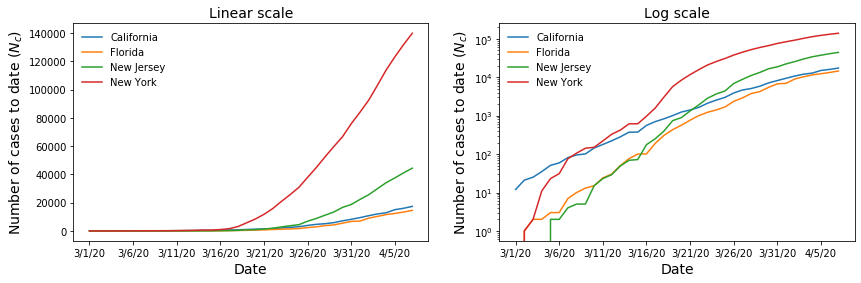

In [4]:
if lastDate == 'today':
    today    = date.today()  #.Today's date.
    lastDate = today.strftime("%-m/%-d/%y")  #.Format like in the JHU data.

if lastDate not in dataJHU:  #.If selected date is not in data set, use the last available date.
    lastDate = dataJHU.columns[-1]

nDays   = len(dataJHU.loc[0,firstDate:lastDate])  #.Number of date records to analyze.
nStates = len(usStates)

#.Extract just the states we are interested in, summed over the counties, and extracts dates of interest.
dataJHUstateTot = dataJHU.groupby('Province_State').sum()
stateData       = dataJHUstateTot.loc[usStates,firstDate:lastDate]

#.Get the total data for each state and plot it.
for p in range(2):
    plt.subplot(1,2,p+1)
    for s in range(nStates):
        stateData.loc[usStates[s],:].plot(figsize=[14,4])
    if p==1:
        plt.yscale('log')
        plt.title(r'Log scale',fontsize=14)
    else:
        plt.title(r'Linear scale',fontsize=14)
    plt.legend(usStates,frameon=False)
    plt.ylabel(r'Number of cases to date ($N_c$)',fontsize=14)
    plt.xlabel(r'Date',fontsize=14)

We will also be interested in the number of new cases per day (stateN), which we can simply estimate by subtracting the cumulative cases up to the date before. In the log-scale plot of new cases per day the time trace can go negative (specially early on) and therefore disappear from the plot because there were decreases from one day to the next.

The plots below also show the smoothed data, using a an average of 'avWindow' days (stateNs).

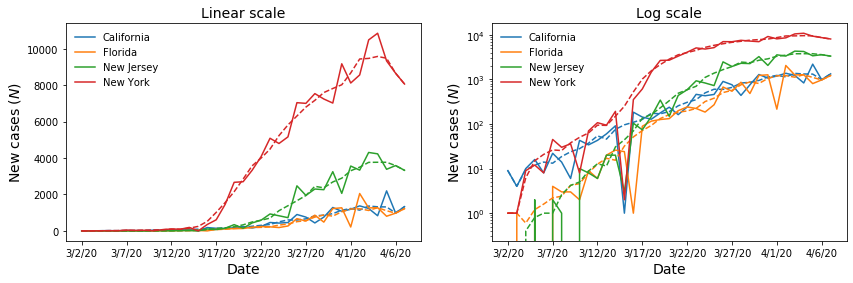

In [7]:
#.Get the total new cases per day for each state and plot it.
avWindow = 5  #.Period (in days) over which to average N(t).

stateN  = (stateData.transpose().drop(firstDate)-stateData.transpose().shift(1).drop(firstDate)).transpose()
#.Smoothed stateN. The ends, were smoothing doesn't work, is replaced with the actual data.
def dataFrameSmoothing(dataIn,avWinIn):
    dataS = dataIn.transpose().rolling(avWinIn,center=True).mean()
    dataS.iloc[0:int(np.ceil((avWinIn-1)/2))] = dataIn.transpose().iloc[0:int(np.ceil((avWinIn-1)/2))]
    dataS.iloc[-int(np.ceil((avWinIn-1)/2)):] = dataIn.transpose().iloc[-int(np.ceil((avWinIn-1)/2)):]
    dataS = dataS.transpose()
    return dataS
stateNs = dataFrameSmoothing(stateN,avWindow)

for p in range(2):
    plt.subplot(1,2,p+1)
    hax = list()
    for s in range(nStates):
        cStateN  = stateN.loc[usStates[s],:]
        cStateNs = stateNs.loc[usStates[s],:]
        hax.append(cStateN.plot(figsize=[14,4], label=usStates[s]))
        cStateNs.plot(linestyle='--',color=plt.gca().lines[-1].get_color(),label='')
    if p==1:
        plt.yscale('log')
        plt.title(r'Log scale',fontsize=14)
    else:
        plt.title(r'Linear scale',fontsize=14)
    hax[0].legend(frameon=False)
    plt.ylabel(r'New cases ($N$)',fontsize=14)
    plt.xlabel(r'Date',fontsize=14)

There is much discussion about the rate of change, growth rates, and what the most meaningful quantity is. It depends on the question being asked. The rate of change in new cases, $dN/dt$, can be estimated with a finite difference:

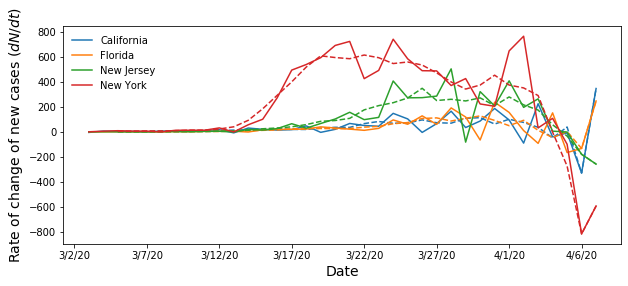

In [8]:
#.Time derivative of new cases per day.
#.Calculate d<N>_t/dt with a finite difference using the smoothed new cases per day, <N>_t.
stateNp = stateNs.transpose().diff().transpose()
#.Smoothed stateN. The ends, were smoothing doesn't work, is replaced with the actual data.
stateNps = dataFrameSmoothing(stateNp,avWindow)

for p in range(1):
    plt.subplot(1,1,p+1)
    hax = list()
    for s in range(nStates):
        cStateNp  = stateNp.loc[usStates[s],:]
        cStateNps = stateNps.loc[usStates[s],:]
        hax.append(cStateNp.plot(figsize=[10,4], label=usStates[s]))
        cStateNps.plot(linestyle='--',color=plt.gca().lines[-1].get_color(),label='')
    if p==1:
        plt.yscale('log')
    plt.legend(frameon=False)
    plt.ylabel(r'Rate of change of new cases ($dN/dt$)',fontsize=14)
    plt.xlabel('Date',fontsize=14)



The above suggests the rate of new diagnoses might've begun to slow down around 03/22/2020. Another meaningful metric is the growth rate in number of new cases per day, $\gamma(t)=(dN/dt)/N$, computed below

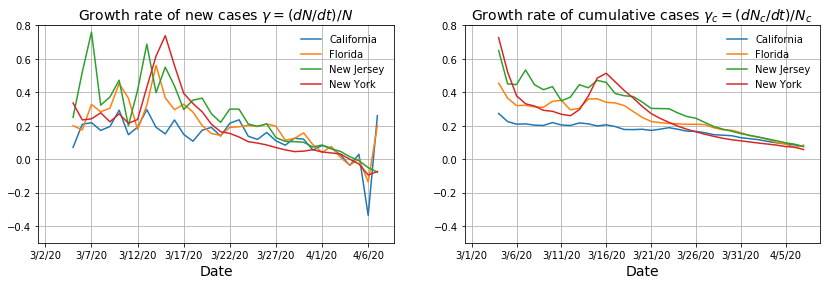

In [19]:
#.Growth rate of new cases per day.
#.First we perform a moving average of N(t), then calculate dN/dt with a finite difference.

stateGamma = stateNps.divide(stateNs)

plt.subplot(1,2,1)
for s in range(nStates):
    cStateGamma = stateGamma.loc[usStates[s],:]
    hax         = cStateGamma.plot(figsize=[14,4])
plt.legend(usStates, frameon=False)
plt.title(r'Growth rate of new cases $\gamma=(dN/dt)/N$',fontsize=14)
plt.xlabel('Date',fontsize=14)    
plt.ylim((-0.5,0.8))
plt.grid()
    
#.Also compute the growth in cumulative cases.
stateNCs    = dataFrameSmoothing(stateData,avWindow)
stateNCp    = stateNCs.transpose().diff().transpose()
stateNCps   = dataFrameSmoothing(stateNCp,avWindow)
stateGammaC = stateNCps.divide(stateNCs)

plt.subplot(1,2,2)
for s in range(nStates):
    cStateGammaC = stateGammaC.loc[usStates[s],:]
    hax          = cStateGammaC.plot(figsize=[14,4])
plt.legend(usStates, frameon=False)
plt.title(r'Growth rate of cumulative cases $\gamma_c=(dN_c/dt)/N_c$',fontsize=14)
plt.xlabel('Date',fontsize=14)    
plt.ylim((-0.5,0.8))
plt.grid()

Above we have also shown the growth rate in the number of cumulative cases, $N_c$, for comparison.